# Classical QNNs and Hybrid QNNs

This notebook demonstrates the difference between a `Classical NN Model` and a `Hybrid QNN Model` used on the MNIST Dataset.

# Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

algorithm_globals.random_seed = 42

In [2]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Loading Data for both QNN and CNN

We take advantage of the `torchvision` [API](https://pytorch.org/vision/stable/datasets.html) to directly load a subset of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) and define torch `DataLoaders` for train and test.

In [3]:
manual_seed(42)

batch_size = 1
n_samples = 20000

X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In a quick visualization, we can see that we have extracted 0s and 1s into the train dataset.

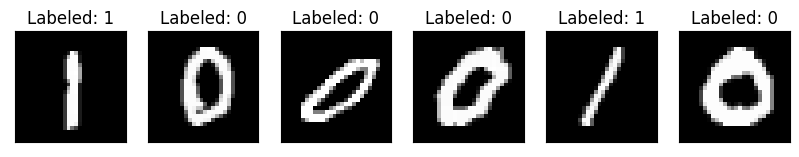

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

Again, we are extracting 0s and 1s for the test dataset.

In [17]:
n_samples = 20000

X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

# Defining Models for Both

In [6]:
# Define classical NN module
class Classical_Net(Module):
    def __init__(self):
        super(Classical_Net, self).__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = Classical_Net()

## Creating QNN circuit  

Here we are using a ZZFeatureMap and an ansatz with 2 qubits and a repitition value of 1.

In [21]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn_og = create_qnn()

## Fixing Optimizer

In [9]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model.train()  # Set model to training mode

Classical_Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

# Training and Testing Models

## Training Classical Neural Network

In [77]:
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    classical_loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, classical_loss_list[-1]))

Training [10%]	Loss: 0.0177
Training [20%]	Loss: 0.0071
Training [30%]	Loss: 0.0068
Training [40%]	Loss: 0.0055
Training [50%]	Loss: 0.0058
Training [60%]	Loss: 0.0059
Training [70%]	Loss: 0.0048
Training [80%]	Loss: 0.0017
Training [90%]	Loss: 0.0048
Training [100%]	Loss: 0.0067


## Testing and Plotting Graphs of Classical Neural Network

### Training Curve

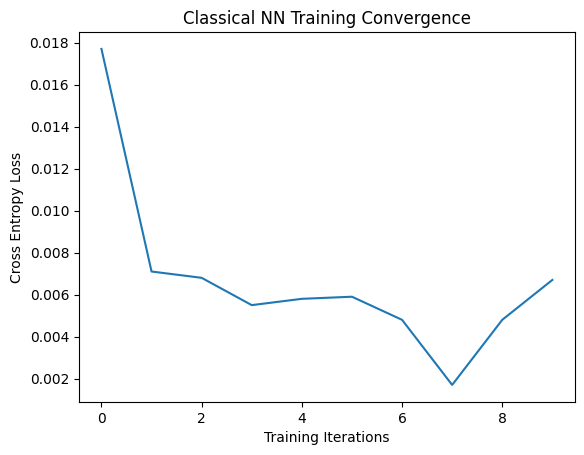

In [102]:
# Plot loss convergence
plt.plot(classical_loss_list)
plt.title("Classical NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

### Saving Model

In [ ]:
torch.save(model.state_dict(), "model_classical.pt")

### Evaluating Model

In [15]:
model_eval = Classical_Net()
model_eval.load_state_dict(torch.load("model_classical.pt"))

<All keys matched successfully>

#### Declaring Variables to store Average Loss and Accuracy values

In [12]:
classical_avg_loss_100 = 0
classical_avg_loss_1000 = 0
classical_avg_loss_10000 = 0
classical_avg_loss_20000 = 0
classical_accuracy_100 = 0
classical_accuracy_1000 = 0
classical_accuracy_10000 = 0
classical_accuracy_20000 = 0

#### With 100 Samples

In [16]:
model_eval.eval()  # Set model to evaluation mode
total_loss = []
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_eval(data)
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        classical_avg_loss_100 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        classical_accuracy_100 = correct / (len(test_loader) * batch_size) * 100
    
    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(classical_avg_loss_100))
    print("\tAccuracy: {:.1f}%".format(classical_accuracy_100))

Performance on test data:
	Loss: 0.0000
	Accuracy: 100.0%


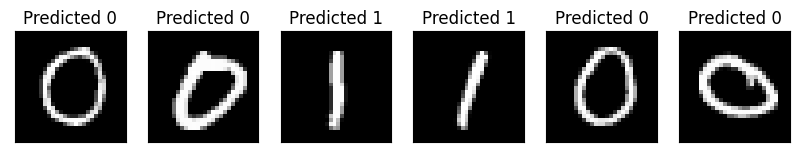

In [125]:
# Plot predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_eval.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 1000 Samples

In [127]:
model_eval.eval()  # Set model to evaluation mode
total_loss = []
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_eval(data)
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        classical_avg_loss_1000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        classical_accuracy_1000 = correct / (len(test_loader) * batch_size) * 100
    
    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(classical_avg_loss_1000))
    print("\tAccuracy: {:.1f}%".format(classical_accuracy_1000))

Performance on test data:
	Loss: 0.0148
	Accuracy: 99.8%


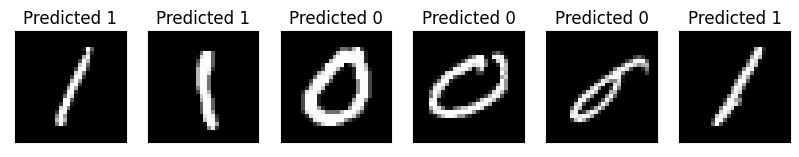

In [128]:
# Plot predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_eval.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 10000 Samples

In [130]:
model_eval.eval()  # Set model to evaluation mode
total_loss = []
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_eval(data)
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        classical_avg_loss_10000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        classical_accuracy_10000 = correct / (len(test_loader) * batch_size) * 100
    
    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(classical_avg_loss_10000))
    print("\tAccuracy: {:.1f}%".format(classical_accuracy_10000))

Performance on test data:
	Loss: 0.0139
	Accuracy: 99.8%


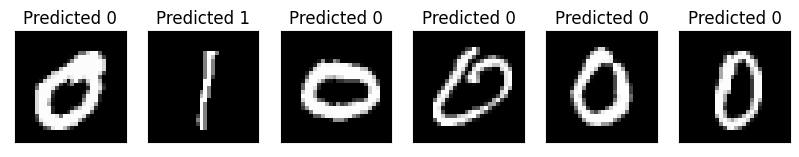

In [131]:
# Plot predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_eval.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 20000 Samples

In [134]:
model_eval.eval()  # Set model to evaluation mode
total_loss = []
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_eval(data)
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        classical_avg_loss_20000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        classical_accuracy_20000 = correct / (len(test_loader) * batch_size) * 100
    
    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(classical_avg_loss_20000))
    print("\tAccuracy: {:.1f}%".format(classical_accuracy_20000))

Performance on test data:
	Loss: 0.0139
	Accuracy: 99.8%


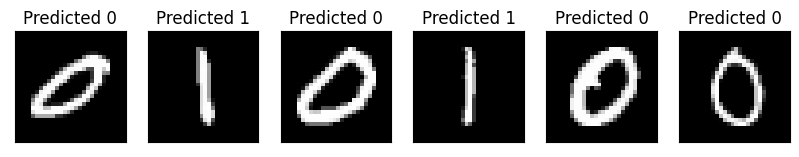

In [135]:
# Plot predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_eval.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.unsqueeze(0)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

## Training Hybrid Neural Network

In [22]:
# Define torch NN module
class QNN_Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2) 
        self.qnn = TorchConnector(qnn)  
        self.fc3 = Linear(1, 1)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model_qnn = QNN_Net(qnn_og)

In [80]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model_qnn.parameters(), lr=0.001)
loss_func = NLLLoss()

epochs = 10  
qnn_loss_list = [] 
model_qnn.train() 

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  
        output = model_qnn(data)  
        loss = loss_func(output, target)  
        loss.backward()  
        optimizer.step()  
        total_loss.append(loss.item()) 
    qnn_loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, qnn_loss_list[-1]))

Training [10%]	Loss: -1.4124
Training [20%]	Loss: -9.5982
Training [30%]	Loss: -19.5862
Training [40%]	Loss: -26.0790
Training [50%]	Loss: -33.4969
Training [60%]	Loss: -47.7784
Training [70%]	Loss: -51.2643
Training [80%]	Loss: -74.0540
Training [90%]	Loss: -82.5714
Training [100%]	Loss: -35.6456


## Testing and Plotting Graphs of Hybrid Neural Network

### Training Curve

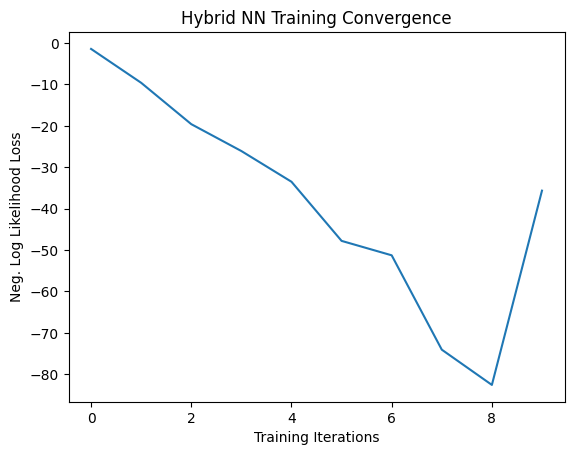

In [140]:
# Plot loss convergence
plt.plot(qnn_loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Now we'll save the trained model, just to show how a hybrid model can be saved and re-used later for inference.

In [88]:
torch.save(model_qnn.state_dict(), "model_qnn.pt")

We start from recreating the model and loading the state from the previously saved file.

In [20]:
qnn = create_qnn()
model_qnn_eval = QNN_Net(qnn)
model_qnn_eval.load_state_dict(torch.load("model_qnn.pt"))

Traceback (most recent call last):
  Cell In[20], line 3
    model_qnn_eval.load_state_dict(torch.load("model_qnn.pt"))
  File /opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:2041 in load_state_dict
    raise RuntimeError('Error(s) in loading state_dict for {}:\n\t{}'.format(
RuntimeError: Error(s) in loading state_dict for QNN_Net:
	size mismatch for qnn.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for qnn._weights: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([6]).

Use %tb to get the full traceback.


### Evaluating Model

#### Declaring Variables to store Average Loss and Accuracy values

In [148]:
qnn_avg_loss_100 = 0
qnn_avg_loss_1000 = 0
qnn_avg_loss_10000 = 0
qnn_avg_loss_20000 = 0
qnn_accuracy_100 = 0
qnn_accuracy_1000 = 0
qnn_accuracy_10000 = 0
qnn_accuracy_20000 = 0

#### With 100 Samples

In [150]:
model_qnn_eval.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_qnn_eval(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        qnn_avg_loss_100 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        qnn_accuracy_100 = correct / (len(test_loader) * batch_size) * 100

    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(qnn_avg_loss_100))
    print("\tAccuracy: {:.1f}%".format(qnn_accuracy_100))

Performance on test data:
	Loss: -5.2261
	Accuracy: 83.5%


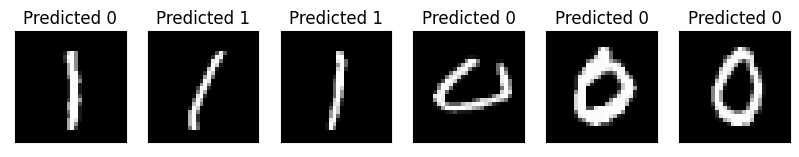

In [151]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_qnn_eval.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_qnn_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 1000 Samples

In [153]:
model_qnn_eval.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_qnn_eval(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        qnn_avg_loss_1000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        qnn_accuracy_1000 = correct / (len(test_loader) * batch_size) * 100

    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(qnn_avg_loss_1000))
    print("\tAccuracy: {:.1f}%".format(qnn_accuracy_1000))

Performance on test data:
	Loss: -31.2987
	Accuracy: 85.4%


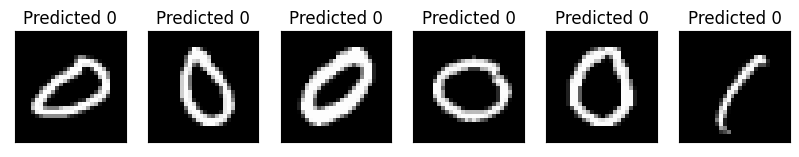

In [154]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_qnn_eval.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_qnn_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 10000 Samples

In [156]:
model_qnn_eval.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_qnn_eval(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        qnn_avg_loss_10000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        qnn_accuracy_10000 = correct / (len(test_loader) * batch_size) * 100

    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(qnn_avg_loss_10000))
    print("\tAccuracy: {:.1f}%".format(qnn_accuracy_10000))

Performance on test data:
	Loss: -40.6285
	Accuracy: 84.4%


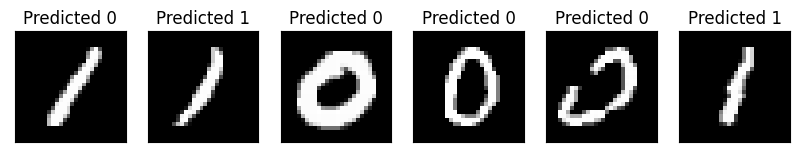

In [157]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_qnn_eval.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_qnn_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

#### With 20000 Samples

In [159]:
model_qnn_eval.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model_qnn_eval(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    if len(total_loss) > 0:
        qnn_avg_loss_20000 = sum(total_loss) / len(total_loss)
    if len(test_loader) > 0:
        qnn_accuracy_20000 = correct / (len(test_loader) * batch_size) * 100

    print("Performance on test data:")
    print("\tLoss: {:.4f}".format(qnn_avg_loss_20000))
    print("\tAccuracy: {:.1f}%".format(qnn_accuracy_20000))

Performance on test data:
	Loss: -45.3290
	Accuracy: 84.4%


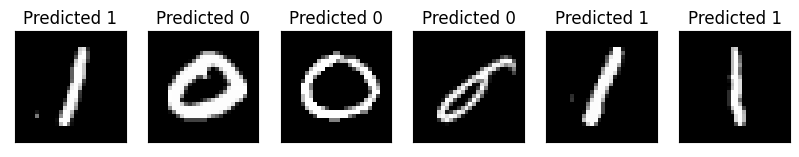

In [160]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_qnn_eval.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_qnn_eval(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

# Comparing Results between CNN and QNN

In [171]:
from tabulate import tabulate

table_data = [
    ["Model", "Average Loss", "Average Accuracy"],
    ["CNN, 100 samples", f"{classical_avg_loss_100:.4f}", f"{classical_accuracy_100:.4f}"],
    ["QNN, 100 samples", f"{qnn_avg_loss_100:.4f}", f"{qnn_accuracy_100:.4f}"],
    ["-", "-", "-"],
    ["CNN, 1000 samples", f"{classical_avg_loss_1000:.4f}", f"{classical_accuracy_1000:.4f}"],
    ["QNN, 1000 samples", f"{qnn_avg_loss_1000:.4f}", f"{qnn_accuracy_1000:.4f}"],
    ["-", "-", "-"],
    ["CNN, 10000 samples", f"{classical_avg_loss_10000:.4f}", f"{classical_accuracy_10000:.4f}"],
    ["QNN, 10000 samples", f"{qnn_avg_loss_10000:.4f}", f"{qnn_accuracy_10000:.4f}"],
    ["-", "-", "-"],
    ["CNN, 20000 samples", f"{classical_avg_loss_20000:.4f}", f"{classical_accuracy_20000:.4f}"],
    ["QNN, 20000 samples", f"{qnn_avg_loss_20000:.4f}", f"{qnn_accuracy_20000:.4f}"],
]

table = tabulate(table_data, headers="firstrow", tablefmt="fancy_grid")
print(table)

╒════════════════════╤════════════════╤════════════════════╕
│ Model              │ Average Loss   │ Average Accuracy   │
╞════════════════════╪════════════════╪════════════════════╡
│ CNN, 100 samples   │ 0.0000         │ 100.0000           │
├────────────────────┼────────────────┼────────────────────┤
│ QNN, 100 samples   │ -5.2261        │ 83.5000            │
├────────────────────┼────────────────┼────────────────────┤
│ -                  │ -              │ -                  │
├────────────────────┼────────────────┼────────────────────┤
│ CNN, 1000 samples  │ 0.0148         │ 99.7980            │
├────────────────────┼────────────────┼────────────────────┤
│ QNN, 1000 samples  │ -31.2987       │ 85.4040            │
├────────────────────┼────────────────┼────────────────────┤
│ -                  │ -              │ -                  │
├────────────────────┼────────────────┼────────────────────┤
│ CNN, 10000 samples │ 0.0139         │ 99.8109            │
├────────────────────┼──

## Results Discussion

* Firstly, both the models use different Loss Functions, hence the disparity in the values. The CNN uses the Cross Entropy Loss function and QNN uses the Negative Log Likelihood Loss function. For CNN, the average loss is 0 at 100 samples because there are too few samples and so the model can classify the data easily. As the number of samples increases, we can see that the average loss values for both models decrease, indicating the fact that the models are becoming better at predicting outputs. 
* The accuracy for CNN remains relatively constant as the number of samples increases. On the other hand, the accuracy increases for QNN as the number of samples increases up to a certain point after which, the accuracy starts to decrease. This shows that the QNN becomes worse at generalizing the data at higher numbers of samples. 
* We also have to take into account that CNN consistently performs at a higher accuracy compared to QNN. This may be due to the fact the QNN model is a hybrid model and we are implementing a quantum circuit in a traditional neural network. If this was a quantum model built from scratch, maybe the QNN could have given better results. 
* Overall, there is a good scope for improvement in our implementation of a QNN.